In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, hstack, join
import dustmaps.bayestar, dustmaps.sfd
import astropy.units as units
from astropy.coordinates import SkyCoord

# Question
Can we numerically marginalize over parallaxes by doing a rough discrete integral over a grid? How accurate is it when we add an HRD/CMD prior that shrinks the parallax uncertainties and make the PDF non-Gaussian?

# Answer: yes!
By doing a rough trapezoidal integral on 5-10 points in the interval varpimean +- 3*varpierror we are actually capturing most of the power of all objects. This seems to be a reliable approximation for marginalizing over parallax in hierarchical models.

In [2]:
data_tgas = Table.read('../tgas-source.fits')
data_apass = Table.read('../tgas-matched-apass-dr9.fits')
data_apass.rename_column('matched', 'matched_apass')
data_apass.rename_column('matchdist', 'matchdist_apass')
data_join = hstack((data_apass, data_tgas['source_id', 'l', 'b', 'parallax', 'parallax_error', 'phot_g_mean_mag']))
len(data_join), data_join.colnames

(2057050,
 ['ra',
  'dec',
  'bmag',
  'vmag',
  'gmag',
  'rmag',
  'imag',
  'e_bmag',
  'e_vmag',
  'e_gmag',
  'e_rmag',
  'e_imag',
  'matched_apass',
  'matchdist_apass',
  'source_id',
  'l',
  'b',
  'parallax',
  'parallax_error',
  'phot_g_mean_mag'])

In [3]:
ind = np.repeat(True, len(data_join))
ind &= data_join['matched_apass']
ind &= np.isfinite(data_join['vmag'])
ind &= np.isfinite(data_join['bmag'])
ind &= np.isfinite(data_join['parallax'])
ind &= np.isfinite(data_join['e_vmag'])
ind &= np.isfinite(data_join['e_bmag'])
ind &= np.isfinite(data_join['parallax_error'])
ind &= data_join['e_vmag'] > 0
ind &= data_join['e_bmag'] > 0
ind &= data_join['parallax_error'] > 0
ind &= (data_join['parallax'] / data_join['parallax_error'] > 1/1) # Main cut
print('Number of objects=', ind.sum())
df = data_join[ind].to_pandas()
df.describe()

/Users/bl/anaconda/lib/python3.5/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


Number of objects= 1464782


,ra,dec,bmag,vmag,gmag,rmag,imag,e_bmag,e_vmag,e_gmag,e_rmag,e_imag,matchdist_apass,source_id,l,b,parallax,parallax_error,phot_g_mean_mag
count,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06
mean,1.816695e+02,-3.101188e+00,1.206702e+01,1.133427e+01,1.169036e+01,1.116519e+01,1.103557e+01,5.475333e-02,4.379613e-02,6.267670e-02,4.169821e-02,6.969434e-02,5.392305e-05,3.646798e+18,1.892242e+02,-1.690342e+00,2.425910e+00,3.797061e-01,1.106769e+01
std,1.013317e+02,4.292381e+01,8.131927e-01,7.759872e-01,7.491655e-01,7.886966e-01,8.394411e-01,8.187632e-02,6.294040e-02,1.125786e-01,6.501273e-02,1.347890e-01,4.968288e-05,2.000933e+18,1.010618e+02,2.958069e+01,2.204461e+00,1.650950e-01,8.320954e-01
min,4.480000e-04,-8.867937e+01,6.032000e+00,5.828000e+00,6.290000e+00,5.738000e+00,4.594000e+00,1.000000e-03,1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.627862e+12,8.787958e-04,-8.987968e+01,2.167810e-01,2.048801e-01,4.649394e+00
25%,9.941414e+01,-4.031799e+01,1.156100e+01,1.081200e+01,1.118900e+01,1.063200e+01,1.050300e+01,2.100000e-02,2.000000e-02,1.800000e-02,1.900000e-02,2.400000e-02,2.141253e-05,1.969698e+18,9.982691e+01,-1.845621e+01,1.137216e+00,2.669441e-01,1.051163e+01
50%,1.718249e+02,-5.352760e+00,1.217600e+01,1.142600e+01,1.177600e+01,1.124100e+01,1.110800e+01,3.300000e-02,3.300000e-02,3.300000e-02,3.200000e-02,4.300000e-02,3.742997e-05,3.611579e+18,1.984313e+02,-1.570938e+00,1.841779e+00,3.193105e-01,1.116613e+01
75%,2.752525e+02,3.443952e+01,1.266700e+01,1.191700e+01,1.224700e+01,1.175300e+01,1.164700e+01,5.600000e-02,5.300000e-02,6.400000e-02,5.100000e-02,7.000000e-02,6.725873e-05,5.509087e+18,2.774967e+02,1.535374e+01,2.993496e+00,4.281026e-01,1.168366e+01
max,3.599999e+02,8.867352e+01,1.728600e+01,1.539800e+01,1.830900e+01,1.746200e+01,1.773700e+01,4.936000e+00,5.191000e+00,6.850000e+00,5.577000e+00,5.884000e+00,2.777731e-04,6.917494e+18,3.599988e+02,8.989966e+01,1.205942e+02,9.999978e-01,1.569592e+01


In [4]:
bayestar = dustmaps.bayestar.BayestarQuery(max_samples=2)
sfd = dustmaps.sfd.SFDQuery()

In [5]:
nobj = int(1e5) # 
sel = np.random.choice(len(df), nobj, replace=False)

obsvarpis = df[['parallax']].values[sel, :].ravel().astype(np.double)
obsvarpis_err = df[['parallax_error']].values[sel, :].ravel().astype(np.double)
obsvarpis_var = obsvarpis_err**2.0

ls = df[['l']].values[sel, :].ravel().astype(np.double)
bs = df[['b']].values[sel, :].ravel().astype(np.double)
distances = (1000/obsvarpis)
coords = SkyCoord(ls*units.deg, bs*units.deg, distance=distances*units.pc, frame='galactic')
ras, decs = coords.icrs.ra.rad, coords.icrs.dec.rad
ebv = bayestar(coords, mode='median')
ebv2 = sfd(coords)
ind2 = ~np.isfinite(ebv)
ebv[ind2] = 0 #ebv2[ind2]

B_RedCoeff = 3.626
V_RedCoeff = 2.742

obsmags = df[['vmag']].values[sel, :].astype(np.double).ravel() 
obsmags_var = df[['e_vmag']].values[sel, :].astype(np.double).ravel() ** 2.0
obscolors = df[['bmag']].values[sel, :].astype(np.double).ravel() - obsmags
obscolors_var = df[['e_bmag']].values[sel, :].astype(np.double).ravel()**2.0 + obsmags_var

dustamps = ebv.astype(np.double)
dustcoefs = np.array([V_RedCoeff, B_RedCoeff - V_RedCoeff])
    
obsabsmag = obsmags + 5*np.log10(obsvarpis) - 10
obsabsmagG = df[['phot_g_mean_mag']].values[sel, :].astype(np.double).ravel() + 5*np.log10(obsvarpis) - 10
obsabsmag.min(), obsabsmag.max(), obscolors.min(), obscolors.max()

ras = np.asarray(data_tgas['ra'][sel]).astype('f8')
decs = np.asarray(data_tgas['dec'][sel]).astype('f8')
pms_ra = np.asarray(data_tgas['pmra'][sel]).astype('f8')
pms_dec = np.asarray(data_tgas['pmdec'][sel]).astype('f8')

sigs_pmra = np.asarray(data_tgas['pmra_error'][sel]).astype('f8')
sigs_pmdec = np.asarray(data_tgas['pmdec_error'][sel]).astype('f8')
sigs_parallax = np.asarray(data_tgas['parallax_error'][sel]).astype('f8')
covs_pmra_varpi = np.asarray(data_tgas['parallax_pmra_corr'][sel]).astype('f8') * sigs_pmra * sigs_parallax
covs_pmdec_varpi = np.asarray(data_tgas['parallax_pmdec_corr'][sel]).astype('f8') * sigs_pmdec * sigs_parallax
covs_pmra_pmdec = np.asarray(data_tgas['pmra_pmdec_corr'][sel]) * sigs_pmra * sigs_pmdec

mus_varpi_covar = np.zeros((sel.size, 3, 3))
mus_varpi_covar[:, 0, 0] = sigs_pmra**2
mus_varpi_covar[:, 0, 1] = covs_pmra_pmdec
mus_varpi_covar[:, 0, 2] = covs_pmra_varpi
mus_varpi_covar[:, 1, 0] = covs_pmra_pmdec
mus_varpi_covar[:, 1, 1] = sigs_pmdec**2
mus_varpi_covar[:, 1, 2] = covs_pmdec_varpi
mus_varpi_covar[:, 2, 0] = covs_pmra_varpi
mus_varpi_covar[:, 2, 1] = covs_pmdec_varpi
mus_varpi_covar[:, 2, 2] = sigs_parallax**2


/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median for 32061 results
  r = func(a, **kwargs)


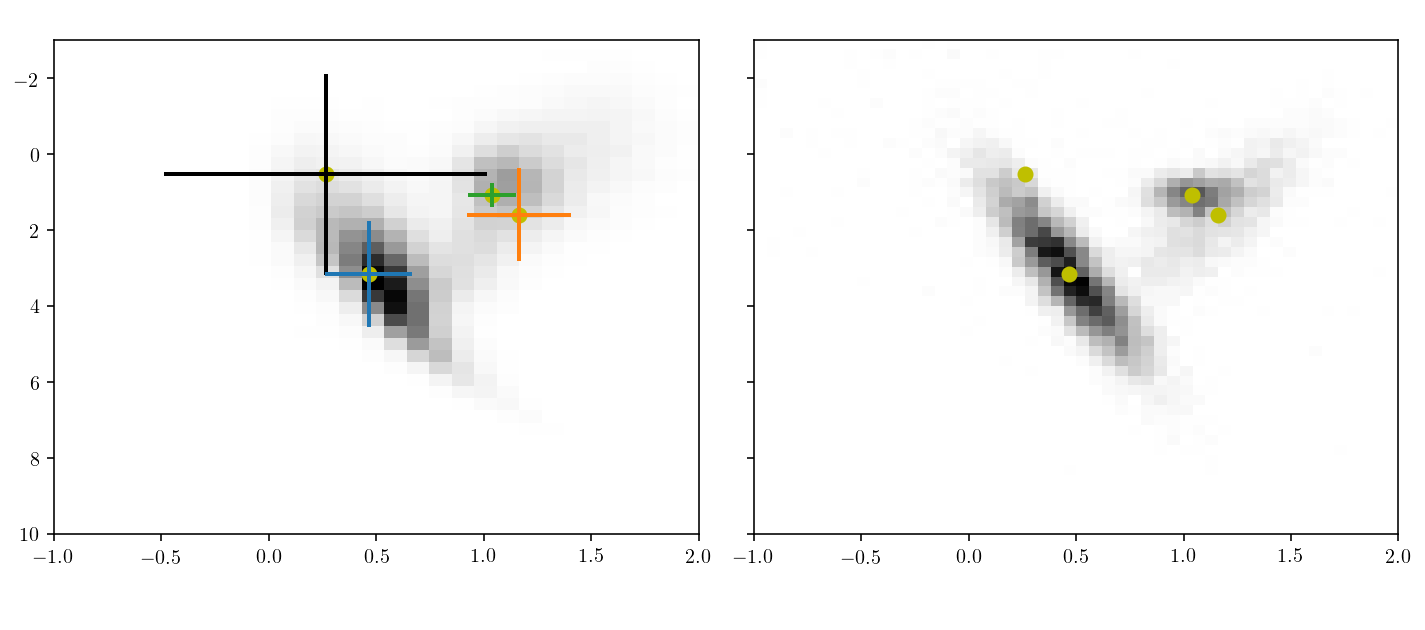

In [6]:
def convert_params(params, nbins):
    zs = params[0:nbins-1]
    binmus = params[nbins-1:3*nbins-1].reshape((2, nbins)).T
    binvars = params[3*nbins-1:5*nbins-1].reshape((2, nbins)).T**2.0
    binrhos = params[5*nbins-1:6*nbins-1].reshape((nbins, 1))
    fac = np.array([1.0]*nbins)
    zsb = np.array([1.0]*nbins)
    for i in range(nbins-1):
        fac[i] = 1. - zs[i]
        zsb[i+1] = zs[i]
    binamps = np.cumprod(zsb) * fac
    return binamps, binmus, binvars, binrhos

samples = np.genfromtxt('/Users/bl/Dropbox/repos/Starlight/notebooks/chains/mixturemodellnprob.txt')
nbins = 4

pos = np.argmin(samples[:, 1])
binamps, binmus, binvars, binrhos = convert_params(samples[pos, 2:], nbins)

bincovars = np.zeros((2, 2, nbins))
for b in range(nbins):
    bincovars[:, :, b] = np.diag(binvars[b, :])
    bincovars[0, 1, b] = np.sqrt(np.prod(binvars[b, :])) * binrhos[b]
    bincovars[1, 0, b] = bincovars[0, 1, b]

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

num = 10000
nbs = np.random.multinomial(num, binamps)
points = np.vstack([np.random.multivariate_normal(binmus[b, :], bincovars[:, :, b], size=nbs[b]) for b in range(nbins)]) 
axs[0].hist2d(obscolors[:].ravel(), obsabsmagG[:], 50, cmap="gray_r")
for b in range(nbins):
    axs[0].errorbar(binmus[b, 1], binmus[b, 0], xerr=binvars[b, 1]**0.5, yerr=binvars[b, 0]**0.5)
    axs[0].scatter(binmus[b, 1], binmus[b, 0], c='y')
    axs[1].scatter(binmus[b, 1], binmus[b, 0], c='y')
axs[1].hist2d(points[:, 1], points[:, 0], 50, cmap="gray_r", range=[[-1, 2], [-3, 10]])
axs[0].set_ylim([10, -3])
axs[0].set_xlim([-1, 2])
    
fig.tight_layout()

In [7]:
def univariate_normal_prob(x, mu, sig):
    return np.exp(-0.5*(x-mu)**2./sig**2) / sig / np.sqrt(2*np.pi)
    
def bivariate_normal_lnprob(x1, x2, mu1, mu2, var1, var2, rho):
    z = (x1 - mu1)**2.0 / var1 + (x2 - mu2)**2.0 / var2\
        - 2 * rho * (x1 - mu1) * (x2 - mu2) / np.sqrt(var1 * var2)
    return - 0.5 * z / (1 - rho*rho) - np.log(2*np.pi)\
         - 0.5 * np.log(var1 * var2 * (1 - rho*rho))
    
def bivariate_normal_prob(x1, x2, mu1, mu2, var1, var2, rho):
    return np.exp(bivariate_normal_lnprob(x1, x2, mu1, mu2, var1, var2, rho))

In [8]:
sel2 = np.arange(nobj)#np.random.choice(nobj, 100000, replace=False)

quantify rough grid approximation to the integral of the likelihood and the posterior
how much of the points of the grid are now negligible?

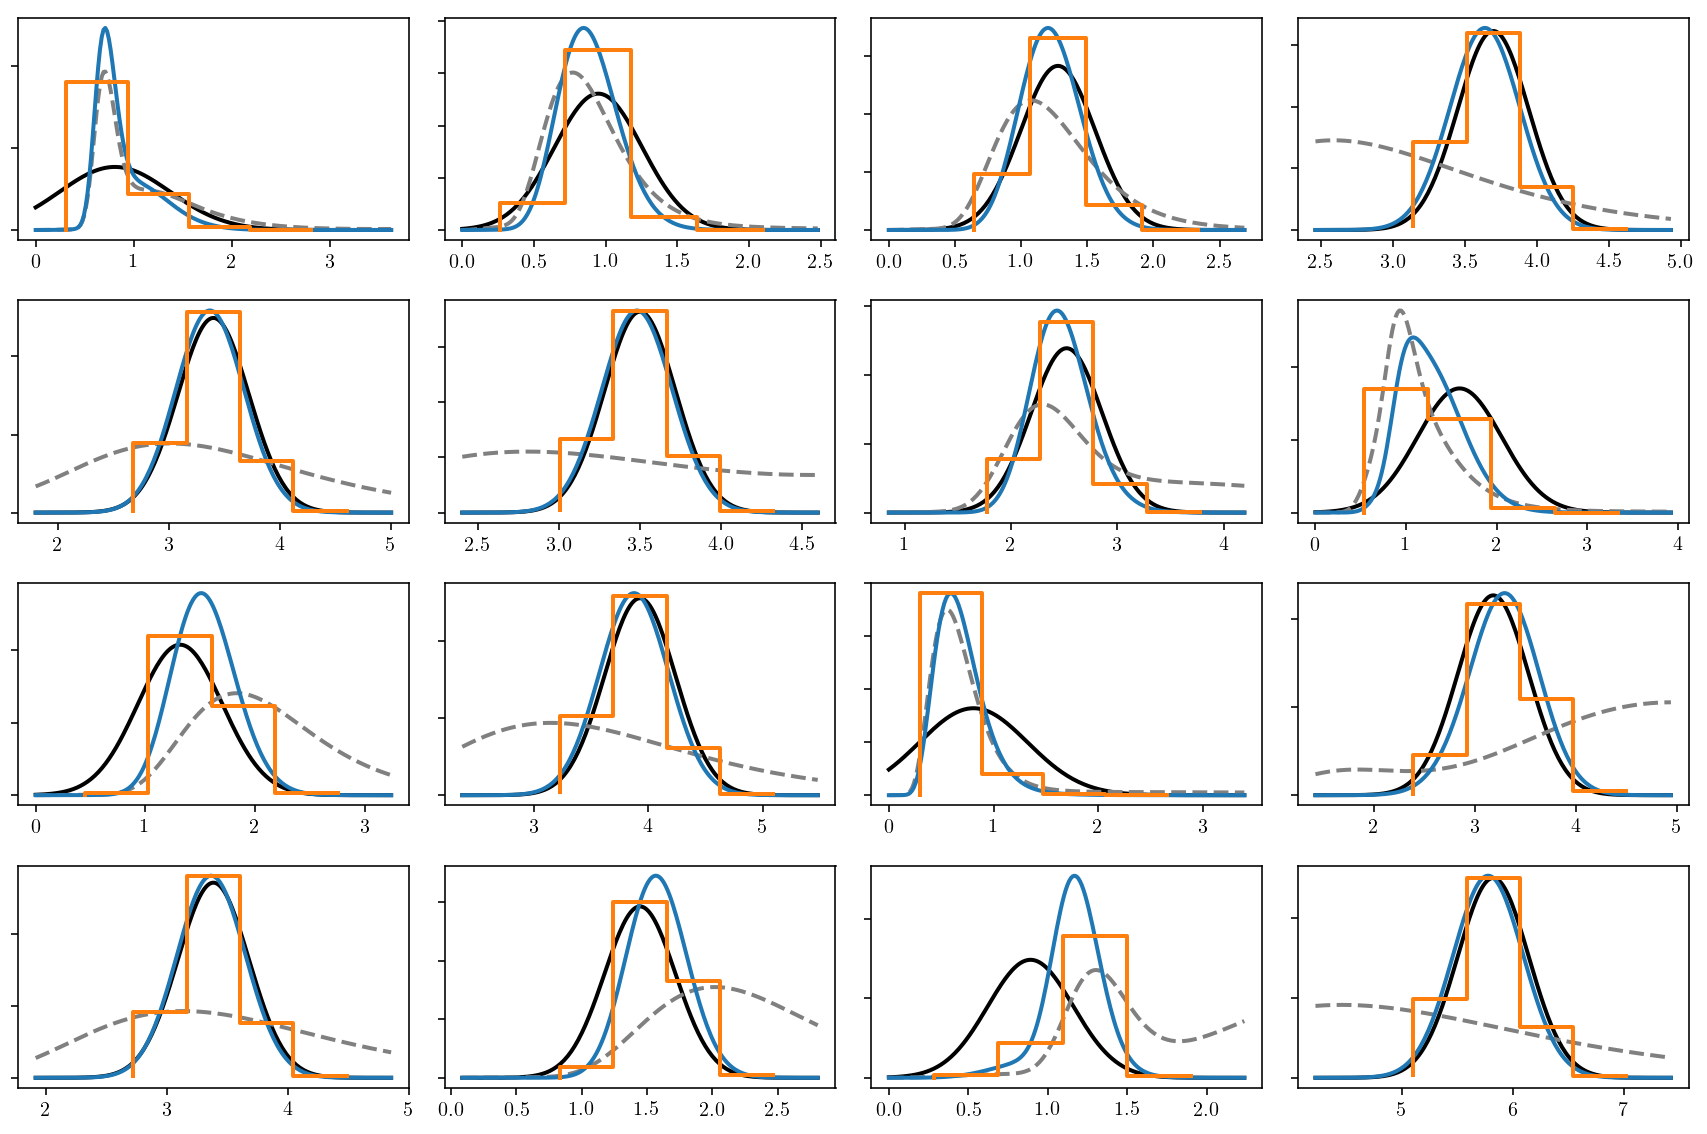

In [9]:
sigma_fine = 5
sigma_rough = 3
ngrid_fine = 200
ngrid_rough = 5

varpis_minmax_fine = np.zeros((sel.size, 2))
varpis_minmax_rough = np.zeros((sel.size, 2))

varpifullposterior_rough_meanvarint = np.zeros((sel.size, 3))
varpifullposterior_fine_meanvarint = np.zeros((sel.size, 3))

fig, axs = plt.subplots(4, 4, figsize=(12, 8))
axs = axs.ravel()
for o, s in enumerate(sel2):
    varpis_minmax_fine[o, 0] = np.max([1e-3, obsvarpis[s] - sigma_fine * obsvarpis_err[s]])
    varpis_minmax_fine[o, 1] = obsvarpis[s] + sigma_fine * obsvarpis_err[s]
    
    varpis_minmax_rough[o, 0] = np.max([1e-3, obsvarpis[s] - sigma_rough * obsvarpis_err[s]])
    varpis_minmax_rough[o, 1] = obsvarpis[s] + sigma_rough * obsvarpis_err[s]
    
    varpigrid_fine = np.linspace(varpis_minmax_fine[o, 0], varpis_minmax_fine[o, 1], ngrid_fine)
    varpilikelihoodgrid_fine = univariate_normal_prob(varpigrid_fine, obsvarpis[s], obsvarpis_err[s])
    varpihrdposteriorgrid_fine = 0*varpigrid_fine
    for b in range(nbins):
        varpihrdposteriorgrid_fine += binamps[b] * bivariate_normal_prob(
                                  binmus[b, 0], 
                                  binmus[b, 1],
                                  obsmags[s] - dustamps[s] * dustcoefs[0] + 5*np.log10(varpigrid_fine) - 10,
                                  obscolors[s] - dustamps[s] * dustcoefs[1], 
                                  obsmags_var[s] + binvars[b, 0],
                                  obscolors_var[s] + binvars[b, 1],
                                  binrhos[b, 0]
                            )
    varpifullposteriorgrid_fine = varpihrdposteriorgrid_fine * varpilikelihoodgrid_fine
    
    varpigrid_rough = np.linspace(varpis_minmax_rough[o, 0], varpis_minmax_rough[o, 1], ngrid_rough)
    varpilikelihoodgrid_rough = univariate_normal_prob(varpigrid_rough, obsvarpis[s], obsvarpis_err[s])
    varpihrdposteriorgrid_rough = 0*varpigrid_rough
    for b in range(nbins):
        varpihrdposteriorgrid_rough += binamps[b] * bivariate_normal_prob(
                                  binmus[b, 0], 
                                  binmus[b, 1],
                                  obsmags[s] - dustamps[s] * dustcoefs[0] + 5*np.log10(varpigrid_rough) - 10,
                                  obscolors[s] - dustamps[s] * dustcoefs[1], 
                                  obsmags_var[s] + binvars[b, 0],
                                  obscolors_var[s] + binvars[b, 1],
                                  binrhos[b, 0]
                            )
    varpifullposteriorgrid_rough = varpihrdposteriorgrid_rough * varpilikelihoodgrid_rough
    
    varpifullposterior_rough_meanvarint[o, 0] = np.average(varpigrid_rough, weights=varpifullposteriorgrid_rough)
    varpifullposterior_rough_meanvarint[o, 1] = np.average((varpigrid_rough - varpifullposterior_rough_meanvarint[o, 0])**2.0, 
                                                        weights=varpifullposteriorgrid_rough)
    varpifullposterior_rough_meanvarint[o, 2] = np.sum(varpifullposteriorgrid_rough) * (varpigrid_rough[1] - varpigrid_rough[0])
    
    varpifullposterior_fine_meanvarint[o, 0] = np.average(varpigrid_fine, weights=varpifullposteriorgrid_fine)
    varpifullposterior_fine_meanvarint[o, 1] = np.average((varpigrid_fine - varpifullposterior_fine_meanvarint[o, 0])**2.0, 
                                                        weights=varpifullposteriorgrid_fine)
    varpifullposterior_fine_meanvarint[o, 2] = np.sum(varpifullposteriorgrid_fine) * (varpigrid_fine[1] - varpigrid_fine[0])
    
    if o < axs.size:
        varpilikelihoodgrid_fine /= np.trapz(varpilikelihoodgrid_fine, x=varpigrid_fine)
        varpihrdposteriorgrid_fine /= np.trapz(varpihrdposteriorgrid_fine, x=varpigrid_fine)
        varpifullposteriorgrid_rough /= np.trapz(varpifullposteriorgrid_fine, x=varpigrid_fine)
        varpifullposteriorgrid_fine /= np.trapz(varpifullposteriorgrid_fine, x=varpigrid_fine)
        axs[o].plot(varpigrid_fine, varpilikelihoodgrid_fine)
        axs[o].plot(varpigrid_fine, varpihrdposteriorgrid_fine, ls='--', c='grey')
        axs[o].plot(varpigrid_fine, varpifullposteriorgrid_fine)
        dv = varpigrid_rough[1] - varpigrid_rough[0]
        axs[o].plot(varpigrid_rough  + dv/2, varpifullposteriorgrid_rough, ls='steps', lw=2)
        axs[o].set_yticklabels([])
    #else:
    #    break

fig.tight_layout()

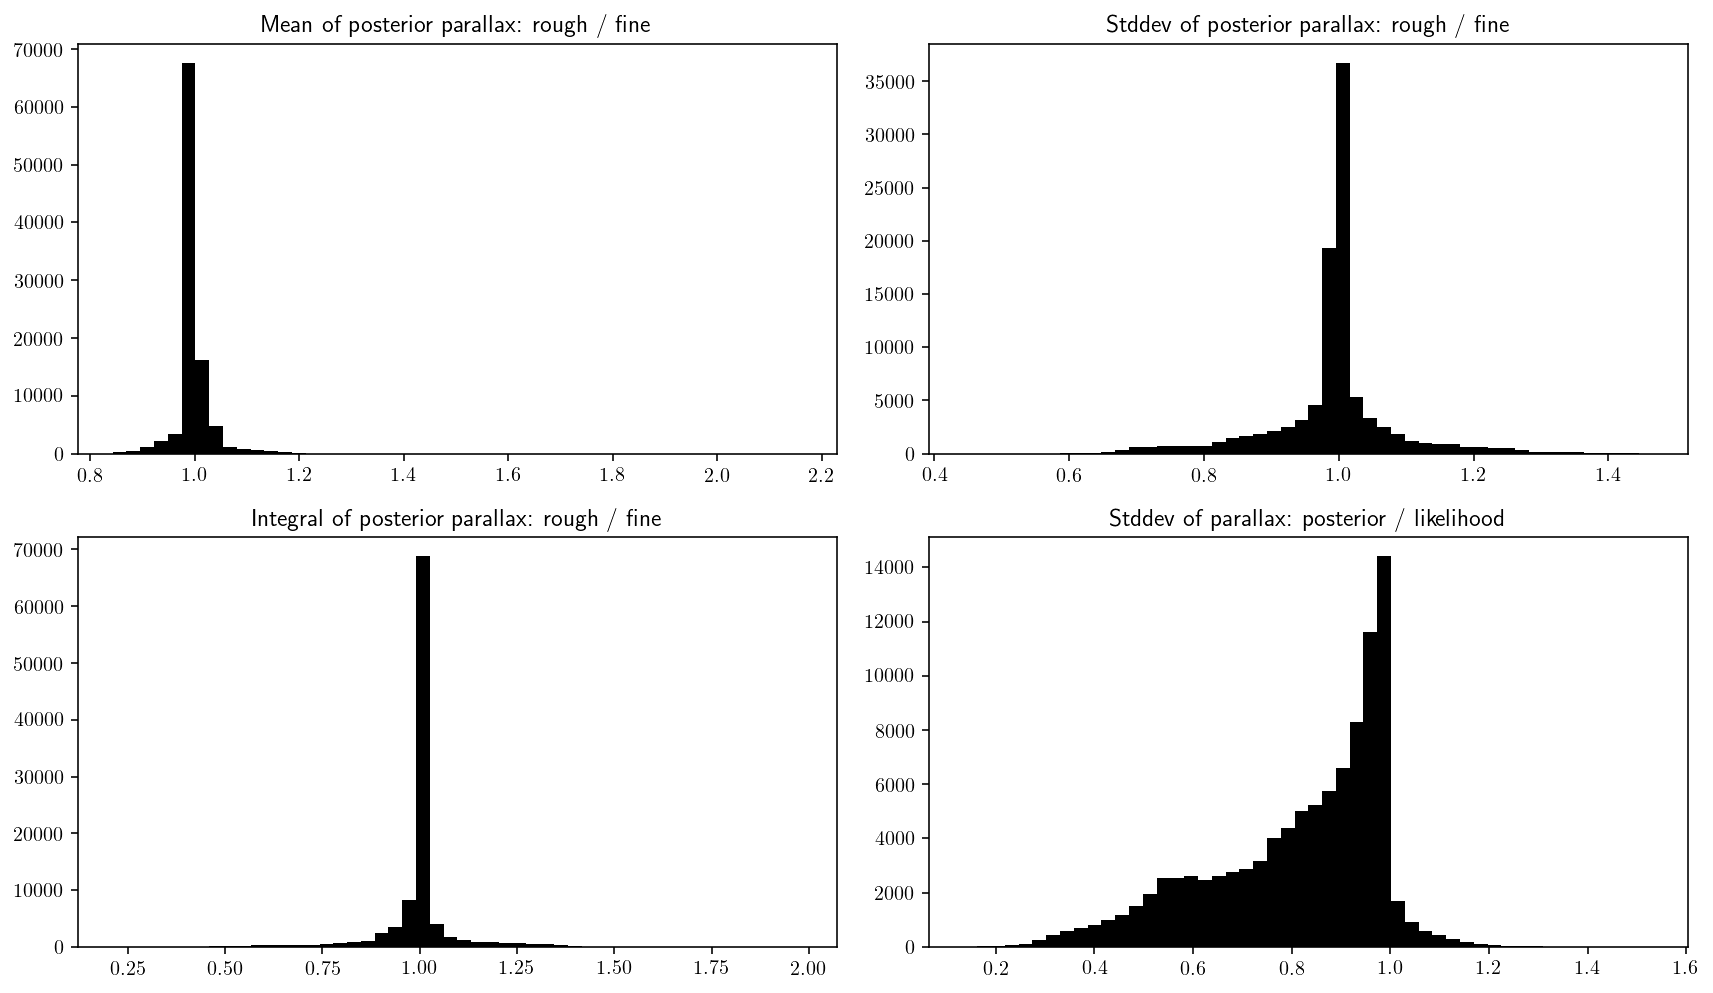

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.ravel()
axs[0].set_title('Mean of posterior parallax: rough / fine')
axs[0].hist(varpifullposterior_rough_meanvarint[:, 0] / varpifullposterior_fine_meanvarint[:, 0], 50)
axs[1].set_title('Stddev of posterior parallax: rough / fine')
axs[1].hist(varpifullposterior_rough_meanvarint[:, 1]**0.5 / varpifullposterior_fine_meanvarint[:, 1]**0.5, 50)
axs[2].set_title('Integral of posterior parallax: rough / fine')
axs[2].hist(varpifullposterior_rough_meanvarint[:, 2] / varpifullposterior_fine_meanvarint[:, 2], 50)
axs[3].set_title('Stddev of parallax: posterior / likelihood')
axs[3].hist(varpifullposterior_rough_meanvarint[:, 1]**0.5 / obsvarpis_err[sel2], 50)
fig.tight_layout()

In [11]:
# our model, again from Bovy, Hogg and Roweis (2009)
nbins = 1
vxyz_amps = np.array([1.0])
vxyz_mus = [np.array([5.5, -6.9, -9.2])]
vxyz_covars = [np.matrix([[700., -110., 60],[-110, 200, 25],[60, -110, 143]])]

In [12]:
# Define the v(r, alpha, delta) to v(x, y, z) matrix projection
# following Bovy, Hogg and Roweis 2009

def xyz_proj_matrix(alpha, delta):
    theta = 123 * np.pi/180
    alpha_NGP = 12.85 * np.pi/180
    delta_NGP = 27.7 * np.pi/180
    A1 = np.matrix([
            [np.cos(alpha), -np.sin(alpha), 0], 
            [np.sin(alpha), np.cos(alpha), 0],
            [0, 0, 1]
        ])
    A2 = np.matrix([
            [np.cos(delta), 0, -np.sin(delta)], 
            [0, 1, 0],
            [np.sin(delta), 0, np.cos(delta)]
        ])
    T1 = np.matrix([
            [np.cos(theta), np.sin(theta), 0], 
            [np.sin(theta), -np.cos(theta), 0],
            [0, 0, 1]
        ])
    T2 = np.matrix([
            [-np.sin(delta_NGP), 0, np.cos(delta_NGP)], 
            [0, 1, 0],
            [np.cos(delta_NGP), 0, np.sin(delta_NGP)]
        ])
    T3 = np.matrix([
            [np.cos(alpha_NGP), np.sin(alpha_NGP), 0], 
            [-np.sin(alpha_NGP), np.cos(alpha_NGP), 0],
            [0, 0, 1]
        ])
    T = np.dot(T1, np.dot(T2, T3))
    A = np.dot(A1, A2)
    R = np.dot(T, A)
    return R

# Invert it and discard v_r component
# Careful: this matrix must be multiplied by varpi
# in order to fully convert v(x, y, z) into PM(alpha, delta)
def xyz2pm(alpha, delta):
    k = 4.74047
    R = xyz_proj_matrix(alpha, delta)
    Rinv = np.linalg.inv(R)
    Rinv[1, :] /= k * np.cos(delta)
    Rinv[2, :] /= k
    return Rinv[1:, :]

def margLike_fast( # This is for *one* star
    varpigrid, # varpi grid to compute the likelihood on
    pm_ra, pm_dec, varpi,  # data (point estimates)
    mu_varpi_covar, # data (covariance of the estimates)
    ra, dec, # position 
    vxyz_amps, vxyz_mus, vxyz_covars): # Gaussian mixture model (three lists containing arrays)
    
    n_comp = len(vxyz_amps) 
    xyz2radec = xyz2pm(np.pi/180 * ra,  np.pi/180 * dec)
    newlikeevals = 0*varpigrid # likelihood evaluated on varpi grid
    for b in range(n_comp): # loop through the components of the miture
        muprior = np.dot(xyz2radec, vxyz_mus[b])
        delta = np.zeros((varpigrid.size, 3)) # model - data
        delta[:, 0] = varpigrid * muprior[0, 0] - pm_ra
        delta[:, 1] = varpigrid * muprior[0, 1] - pm_dec
        delta[:, 2] = varpigrid - varpi
        comp_covar = 1*mu_varpi_covar[None, :, :] * np.ones((varpigrid.size, 1, 1))
        comp_covar[:, :2, :2] += varpigrid[:, None, None]**2. * np.asarray(np.dot(xyz2radec, np.dot(vxyz_covars[b], xyz2radec.T)))[None, :, :]
        newlikeevals[:] += vxyz_amps[b]  / np.linalg.det(comp_covar)**0.5 \
            * np.exp(-0.5*np.sum(delta[:, :]*np.linalg.solve(comp_covar, delta[:, :]), axis=1))
    return newlikeevals

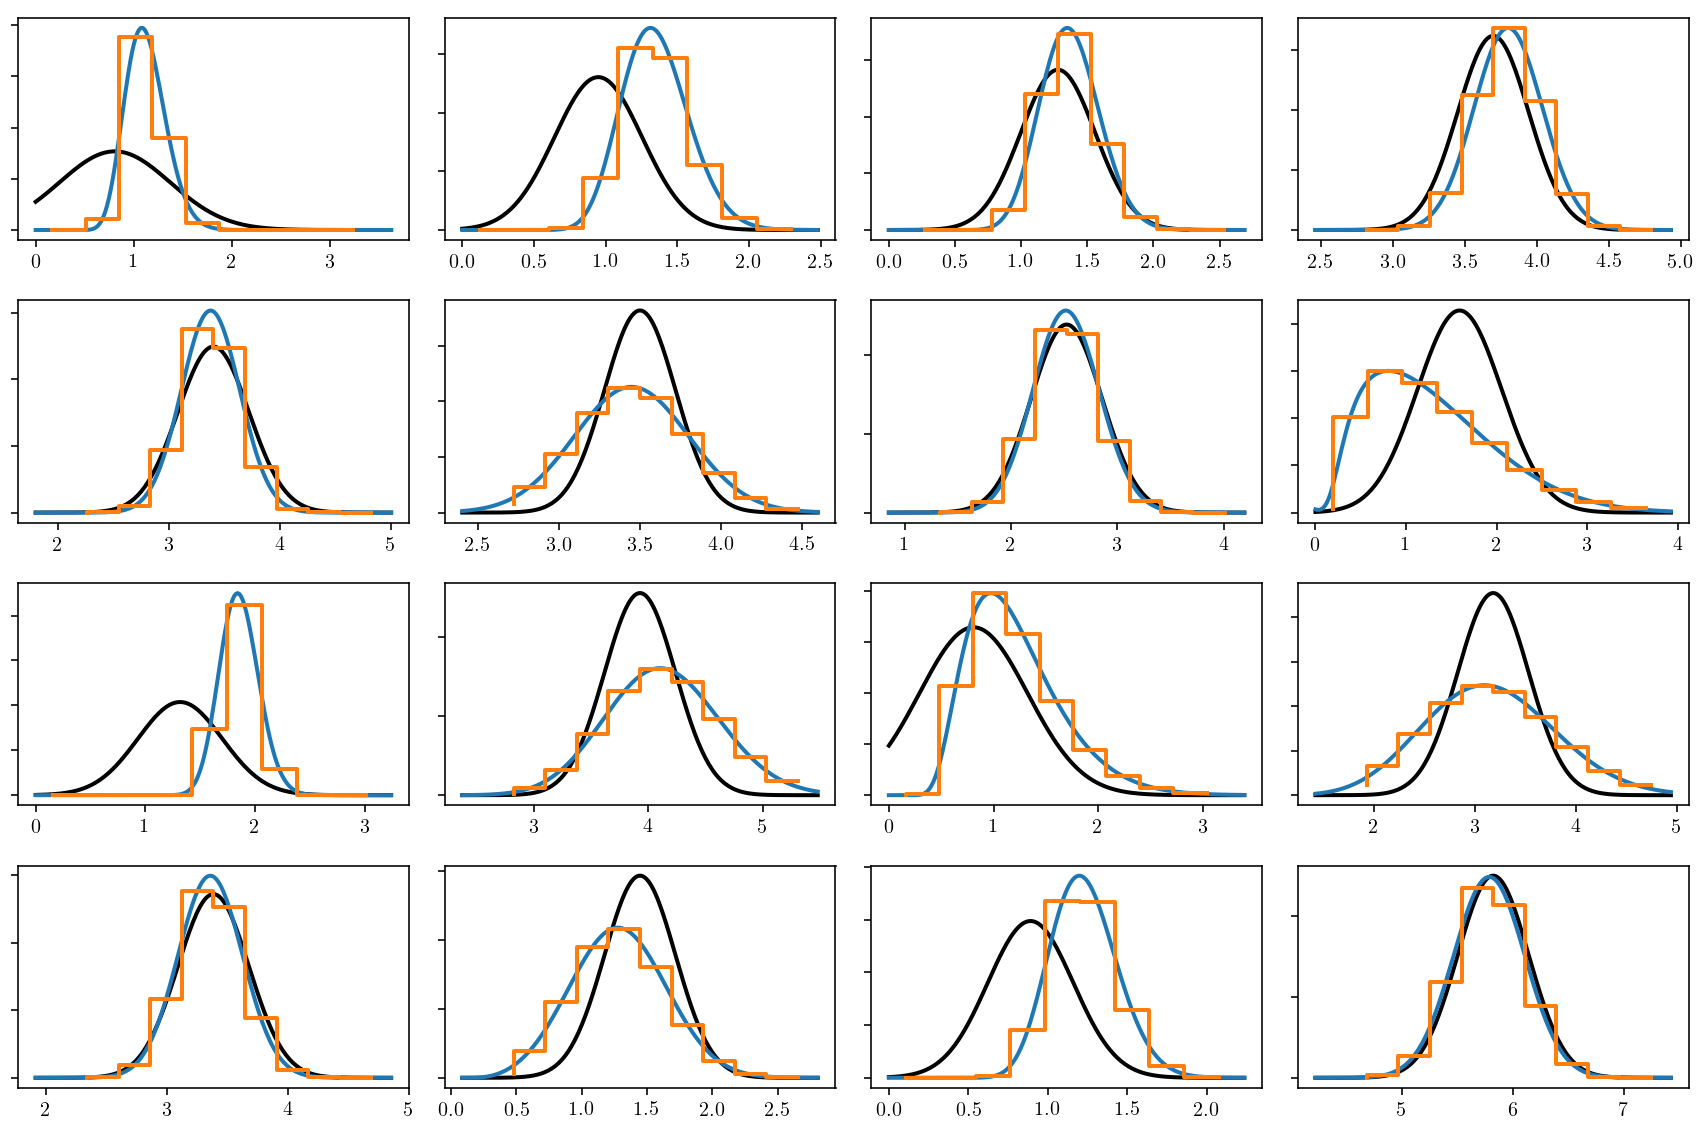

In [17]:

from starlight.models_cy import varpipm_likelihood_velocitybinmarg

sigma_fine = 5
sigma_rough = 4
ngrid_fine = 200
ngrid_rough = 10

varpis_minmax_fine = np.zeros((sel.size, 2))
varpis_minmax_rough = np.zeros((sel.size, 2))

varpifullposterior_rough_meanvarint = np.zeros((sel.size, 3))
varpifullposterior_fine_meanvarint = np.zeros((sel.size, 3))

fig, axs = plt.subplots(4, 4, figsize=(12, 8))
axs = axs.ravel()
for o, s in enumerate(sel2):
    varpis_minmax_fine[o, 0] = np.max([1e-3, obsvarpis[s] - sigma_fine * obsvarpis_err[s]])
    varpis_minmax_fine[o, 1] = obsvarpis[s] + sigma_fine * obsvarpis_err[s]
    
    varpis_minmax_rough[o, 0] = np.max([1e-3, obsvarpis[s] - sigma_rough * obsvarpis_err[s]])
    varpis_minmax_rough[o, 1] = obsvarpis[s] + sigma_rough * obsvarpis_err[s]
    
    varpigrid_fine = np.linspace(varpis_minmax_fine[o, 0], varpis_minmax_fine[o, 1], ngrid_fine)
    varpilikelihoodgrid_fine = univariate_normal_prob(varpigrid_fine, obsvarpis[s], obsvarpis_err[s])
    varpifullposteriorgrid_fine = margLike_fast( 
        varpigrid_fine, pms_ra[o], pms_dec[o], obsvarpis[o],
        mus_varpi_covar[o, :, :], ras[o], decs[o],
        vxyz_amps, vxyz_mus, vxyz_covars)
  
    varpigrid_rough = np.linspace(varpis_minmax_rough[o, 0], varpis_minmax_rough[o, 1], ngrid_rough)
    varpilikelihoodgrid_rough = univariate_normal_prob(varpigrid_rough, obsvarpis[s], obsvarpis_err[s])
    varpifullposteriorgrid_rough = margLike_fast( 
        varpigrid_rough, pms_ra[o], pms_dec[o], obsvarpis[o],
        mus_varpi_covar[o, :, :], ras[o], decs[o],
        vxyz_amps, vxyz_mus, vxyz_covars)

    if varpifullposteriorgrid_rough.sum() > 0:
        varpifullposterior_rough_meanvarint[o, 0] = np.average(varpigrid_rough, weights=varpifullposteriorgrid_rough)
        varpifullposterior_rough_meanvarint[o, 1] = np.average((varpigrid_rough - varpifullposterior_rough_meanvarint[o, 0])**2.0, 
                                                            weights=varpifullposteriorgrid_rough)
        varpifullposterior_rough_meanvarint[o, 2] = np.sum(varpifullposteriorgrid_rough) * (varpigrid_rough[1] - varpigrid_rough[0])
    
    if varpifullposteriorgrid_fine.sum() > 0:
        varpifullposterior_fine_meanvarint[o, 0] = np.average(varpigrid_fine, weights=varpifullposteriorgrid_fine)
        varpifullposterior_fine_meanvarint[o, 1] = np.average((varpigrid_fine - varpifullposterior_fine_meanvarint[o, 0])**2.0, 
                                                            weights=varpifullposteriorgrid_fine)
        varpifullposterior_fine_meanvarint[o, 2] = np.sum(varpifullposteriorgrid_fine) * (varpigrid_fine[1] - varpigrid_fine[0])
    
    if o < axs.size:
        varpilikelihoodgrid_fine /= np.trapz(varpilikelihoodgrid_fine, x=varpigrid_fine)
        varpifullposteriorgrid_rough /= np.trapz(varpifullposteriorgrid_fine, x=varpigrid_fine)
        varpifullposteriorgrid_fine /= np.trapz(varpifullposteriorgrid_fine, x=varpigrid_fine)
        axs[o].plot(varpigrid_fine, varpilikelihoodgrid_fine)
        axs[o].plot(varpigrid_fine, varpifullposteriorgrid_fine)
        dv = varpigrid_rough[1] - varpigrid_rough[0]
        axs[o].plot(varpigrid_rough  + dv/2, varpifullposteriorgrid_rough, ls='steps', lw=2)
        axs[o].set_yticklabels([])
    #else:
    #    break

fig.tight_layout()

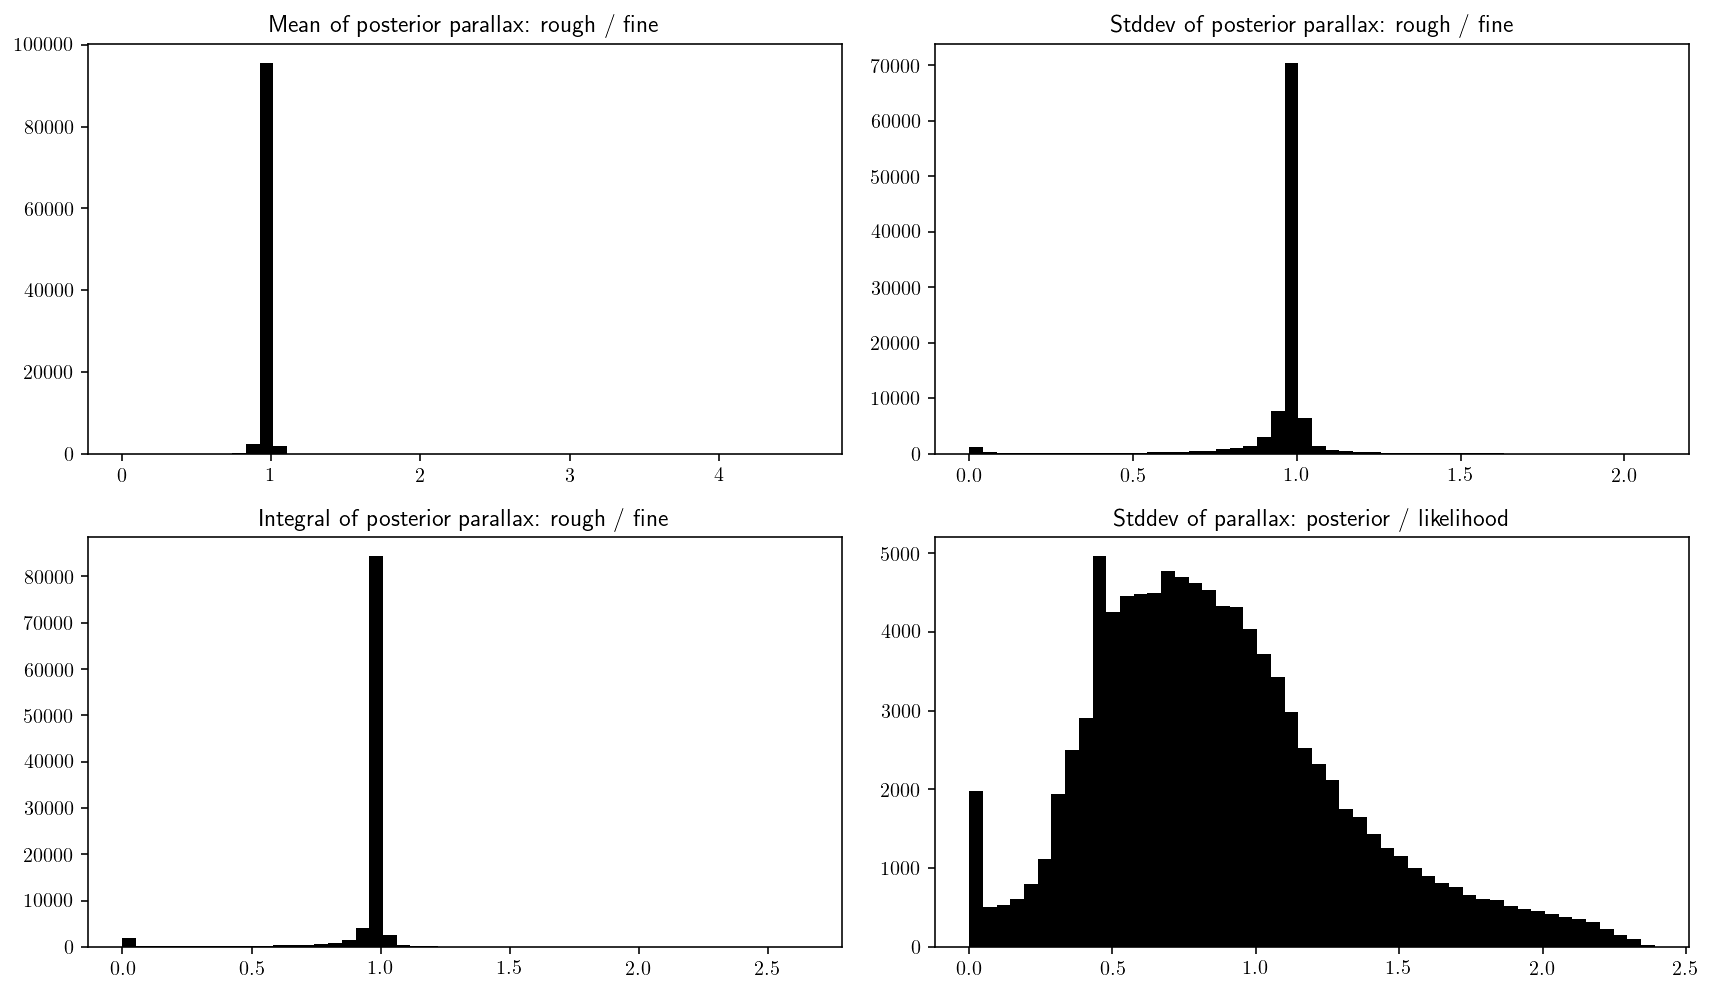

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 7))
axs = axs.ravel()
ind = varpifullposterior_fine_meanvarint[:, 0] > 0
axs[0].set_title('Mean of posterior parallax: rough / fine')
axs[0].hist(varpifullposterior_rough_meanvarint[ind, 0] / varpifullposterior_fine_meanvarint[ind, 0], 50)
ind = varpifullposterior_fine_meanvarint[:, 1] > 0
axs[1].set_title('Stddev of posterior parallax: rough / fine')
axs[1].hist(varpifullposterior_rough_meanvarint[ind, 1]**0.5 / varpifullposterior_fine_meanvarint[ind, 1]**0.5, 50)
ind = varpifullposterior_fine_meanvarint[:, 2] > 0
axs[2].set_title('Integral of posterior parallax: rough / fine')
axs[2].hist(varpifullposterior_rough_meanvarint[ind, 2] / varpifullposterior_fine_meanvarint[ind, 2], 50)
axs[3].set_title('Stddev of parallax: posterior / likelihood')
axs[3].hist(varpifullposterior_rough_meanvarint[:, 1]**0.5 / obsvarpis_err[sel2], 50)
fig.tight_layout()